In [71]:
import pandas as pd
from sqlalchemy import create_engine
import sys
sys.path.append('..')
from src.database_info import database
import matplotlib.pyplot as plt
import seaborn as sns

game_id = '3446534c-ed7f-496c-a8b5-ca346b3d65ba'

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)


engine = create_engine(database)


query = 'SELECT * FROM combos_for_battlefield WHERE higher_post_game_id = %s'
query_2 = '''SELECT lower_post_last_attack_landed, higher_post_last_attack_landed, higher_post_frame, higher_post_internal_character_id, higher_post_action_state_id, higher_post_percent,
lower_post_action_state_id, lower_post_percent, lower_post_internal_character_id, lower_post_l_cancel_status, higher_post_l_cancel_status, higher_post_position_x, higher_post_position_y, lower_post_position_x, lower_post_position_y FROM combos_for_battlefield WHERE higher_post_game_id = %s'''
df = pd.read_sql(query, engine, params=(game_id,))
df_2 = pd.read_sql(query_2, engine, params=(game_id,))


action_state_id_to_check_getting_hit = [0, 1, 2, 4, 8, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 181, 227, 228, 238, 239, 240, 241, 242]
death_action_state_ids = [0, 1, 2, 4, 8]

last_frame = None
current_combo_id = 0
higher_port_post_percent = 0.0
lower_port_post_percent = 0.0

successful_l_cancel = 1
unsuccessful_l_cancel = 0
no_l_cancel_on_frame = None

df_2['combo_block_for_model'] = None
df_2['character_creating_combo_for_model'] = None
df_2['humanlabel'] = None
df_2['first_attack_state_to_hit_in_combo_for_model'] =  None
df_2['last_attack_state_to_hit_in_combo_for_model'] = None
df_2['lower_port_l_cancel_for_model'] = None
df_2['higher_port_l_cancel_for_model'] = None
df_2['lower_port_damage_done_with_combo'] = None
df_2['higher_port_damage_done_with_combo'] = None
df_2['lower_port_damage_done_with_combo_model_score'] = None
df_2['higher_port_damage_done_with_combo_model_score'] = None
df_2['higher_port_x_position_model_score'] = None
df_2['higher_port_y_position_model_score'] = None
df_2['lower_port_x_position_model_score'] = None
df_2['lower_port_y_position_model_score'] = None
df_2['higher_death_state_blocks'] = None
df_2['lower_death_state_blocks'] = None

for index, row in df_2.iterrows():
    current_frame = row['higher_post_frame'] 

    # Check for frame gaps to identify new combos
    if last_frame is not None and (current_frame - last_frame > 1):
        current_combo_id += 1

    # Label based on action_state_id
    if row["lower_post_action_state_id"] not in action_state_id_to_check_getting_hit:#lower port player creating combo
        df_2.at[index, 'combo_block_for_model'] = current_combo_id 
        df_2.at[index, 'character_creating_combo_for_model'] = 0

        if df_2.at[index, 'lower_post_internal_character_id'] == 1:
            df_2.at[index, 'humanlabel'] = 'fox'
        else:
            df_2.at[index, 'humanlabel'] = 'falco'


    elif row["higher_post_action_state_id"] not in action_state_id_to_check_getting_hit: #higher port player creating combo
        df_2.at[index, 'combo_block_for_model'] = current_combo_id 
        df_2.at[index, 'character_creating_combo_for_model'] = 1

        if df_2.at[index, 'higher_post_internal_character_id'] == 1:
            df_2.at[index, 'humanlabel'] = 'fox'
        else:
            df_2.at[index, 'humanlabel'] = 'falco'

    if row['lower_post_action_state_id'] in death_action_state_ids:
        lower_port_post_percent = 0.0
    
    if row['higher_post_action_state_id'] in death_action_state_ids:
        higher_port_post_percent = 0.0

    if row['lower_post_percent'] > lower_port_post_percent and row['lower_post_action_state_id'] not in death_action_state_ids:
        df_2.at[index, 'first_attack_state_to_hit_in_combo_for_model'] = row['higher_post_last_attack_landed']
        lower_port_post_percent = row['lower_post_percent']

    if row['higher_post_percent'] > higher_port_post_percent and row['higher_post_action_state_id'] not in death_action_state_ids:
        df_2.at[index, 'first_attack_state_to_hit_in_combo_for_model'] = row['lower_post_last_attack_landed']
        higher_port_post_percent = row['higher_post_percent']
    
    if row['lower_post_l_cancel_status'] == 0:
        df_2.at[index, 'lower_port_l_cancel_for_model'] = no_l_cancel_on_frame
    
    elif row['lower_post_l_cancel_status'] == 1:
        df_2.at[index, 'lower_port_l_cancel_for_model'] = successful_l_cancel
    
    elif row['lower_post_l_cancel_status'] == 2:
        df_2.at[index, 'lower_port_l_cancel_for_model'] = unsuccessful_l_cancel

    if row['higher_post_l_cancel_status'] == 0:
        df_2.at[index, 'higher_port_l_cancel_for_model'] = no_l_cancel_on_frame
    
    elif row['higher_post_l_cancel_status'] == 1:
        df_2.at[index, 'higher_port_l_cancel_for_model'] = successful_l_cancel
    
    elif row['higher_post_l_cancel_status'] == 2:
        df_2.at[index, 'higher_port_l_cancel_for_model'] = unsuccessful_l_cancel
    
    last_frame = current_frame

    #if the state of the frame before was not in the check to get hit frames and it is now in death action state
    #then we want to label this as dying not in hitstun, and we want to label the combo row as 

grouped = df_2.groupby('combo_block_for_model')

higher_port_previous_end_percent = 0.0
lower_port_previous_end_percent = 0.0

for name, group in grouped:
    # Skip the group if the combo block is marked as 'None'
    if pd.isna(group['combo_block_for_model'].iloc[0]):
        continue

    # Initialize variables to store start and end percents
    start_percent_higher = group['higher_post_percent'].iloc[0] + (higher_port_previous_end_percent - group['higher_post_percent'].iloc[0])
    end_percent_higher = group['higher_post_percent'].iloc[-1]
    start_percent_lower = group['lower_post_percent'].iloc[0] + (lower_port_previous_end_percent - group['lower_post_percent'].iloc[0])
    end_percent_lower = group['lower_post_percent'].iloc[-1]
    
    # Calculate damage done in the combo for each player
    damage_done_to_higher = end_percent_higher - start_percent_higher
    damage_done_to_lower = end_percent_lower - start_percent_lower
    
    # Store the damage done in the last row of the combo block'

    if damage_done_to_higher < 0:
        damage_done_to_higher = None
    
    if damage_done_to_lower < 0:
        damage_done_to_lower = None

    if damage_done_to_lower == 0:
        df_2.at[group.index[-1], 'higher_port_damage_done_with_combo'] = None

    else:
        df_2.at[group.index[-1], 'higher_port_damage_done_with_combo'] = damage_done_to_lower
    

    if damage_done_to_higher == 0:
        df_2.at[group.index[-1], 'lower_port_damage_done_with_combo'] = None

    else:
        df_2.at[group.index[-1], 'lower_port_damage_done_with_combo'] = damage_done_to_higher
    
    # Update the previous end percent for the next iteration
    higher_port_previous_end_percent = end_percent_higher
    lower_port_previous_end_percent = end_percent_lower

#if the character creating the model is 0 then we grab the postion of the higher port, if the character creating the combo is 1 then grab the postion of the lower port

for index, row in df_2.iterrows():

    lower_port_percent_damage_done = row['lower_port_damage_done_with_combo']
    higher_port_percent_damage_done = row['higher_port_damage_done_with_combo']

    if row['lower_port_damage_done_with_combo'] == None:
        df_2.at[index, 'lower_port_damage_done_with_combo_model_score'] = None
    
    else:
        df_2.at[index, 'lower_port_damage_done_with_combo_model_score'] = lower_port_percent_damage_done/100

    if row['higher_port_damage_done_with_combo'] == None:
        df_2.at[index, 'higher_port_damage_done_with_combo_model_score'] = None

    else:
        df_2.at[index, 'higher_port_damage_done_with_combo_model_score'] = higher_port_percent_damage_done/100


# Assuming df_2 is your initial DataFrame and 
# death_action_state_ids is a list of ids indicating death states

# Create masks to identify death state blocks
df_2['higher_death_state_blocks'] = df_2['higher_post_action_state_id'].isin(death_action_state_ids)
df_2['lower_death_state_blocks'] = df_2['lower_post_action_state_id'].isin(death_action_state_ids)

# Create a cumulative sum as a block id for consecutive death states
df_2['higher_block_death_id'] = (~df_2['higher_death_state_blocks']).cumsum()
df_2['lower_block_death_id'] = (~df_2['lower_death_state_blocks']).cumsum()

# Get the first index of each death block for higher and lower death states
first_higher_death_indices = df_2[df_2['higher_death_state_blocks']].groupby('higher_block_death_id').head(1).index
first_lower_death_indices = df_2[df_2['lower_death_state_blocks']].groupby('lower_block_death_id').head(1).index

# Keep only the first occurrence of each block
df_2 = df_2[(df_2.index.isin(first_higher_death_indices)) | (~df_2['higher_death_state_blocks'])]
df_2 = df_2[(df_2.index.isin(first_lower_death_indices)) | (~df_2['lower_death_state_blocks'])]

columns_to_drop = ['higher_death_state_blocks', 'lower_death_state_blocks', 'higher_block_death_id', 'lower_block_death_id']

# Drop the columns from the DataFrame
df_2.drop(columns=columns_to_drop, inplace=True)

html_data = df_2.to_html()

# Write the HTML string to an HTML file
with open('dataframe.html', 'w') as file:
    file.write(html_data)

higher_death_state_rows = df_2[df_2['higher_post_action_state_id'].isin(death_action_state_ids)]
lower_death_state_rows = df_2[df_2['lower_post_action_state_id'].isin(death_action_state_ids)]

print(first_higher_death_state_rows)
print(first_lower_death_state_rows)


      lower_post_last_attack_landed  higher_post_last_attack_landed  higher_post_frame  higher_post_internal_character_id  higher_post_action_state_id  higher_post_percent  lower_post_action_state_id  lower_post_percent  lower_post_internal_character_id  lower_post_l_cancel_status  higher_post_l_cancel_status  higher_post_position_x  higher_post_position_y  lower_post_position_x  lower_post_position_y combo_block_for_model character_creating_combo_for_model humanlabel first_attack_state_to_hit_in_combo_for_model last_attack_state_to_hit_in_combo_for_model lower_port_l_cancel_for_model higher_port_l_cancel_for_model lower_port_damage_done_with_combo higher_port_damage_done_with_combo lower_port_damage_done_with_combo_model_score higher_port_damage_done_with_combo_model_score higher_port_x_position_model_score higher_port_y_position_model_score lower_port_x_position_model_score lower_port_y_position_model_score  higher_death_state_blocks  lower_death_state_blocks  \
1164                 

In [26]:
pd.set_option('display.max_rows', 1000)
df['higher_post_action_state_id'].value_counts()

filtered_df = df[df['higher_post_action_state_id'] == 67]
print(filtered_df)



      higher_post_id  higher_post_frame  higher_post_player_index  higher_post_is_follower  higher_post_internal_character_id  higher_post_action_state_id  higher_post_position_x  higher_post_position_y  higher_post_facing_direction  higher_post_percent  higher_post_shield_size  higher_post_last_attack_landed  higher_post_last_hit_by  higher_post_stocks_remaining  higher_post_action_state_counter  higher_post_misc_action_state  higher_post_is_airborne  higher_post_last_ground_id  higher_post_jumps_remaining  higher_post_l_cancel_status  higher_post_hurtbox_collision_state  higher_post_hitlag_remaining  higher_post_animation_index  higher_post_self_induced_speeds_air_x  higher_post_self_induced_speeds_y  higher_post_self_induced_speeds_attack_x  higher_post_self_induced_speeds_attack_y  higher_post_self_induced_speeds_ground_x                   higher_post_game_id  higher_pre_id  higher_pre_frame  higher_pre_player_index  higher_pre_is_follower  higher_pre_seed  \
549             1915  

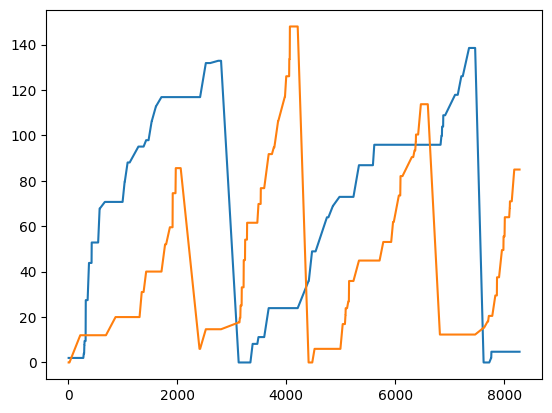

In [16]:
plt.plot(df['higher_post_frame'], df['higher_post_percent'])
plt.plot(df['lower_post_frame'], df['lower_post_percent'])
plt.show()
